# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [42]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


# 1. Load Dataset

In [43]:
df = pd.read_csv('./trainset/J0003_0024_0222_20110307012737_cell_1.csv')
# 한국 일일확진자 변수 제거
#df.drop(['Unnamed: 0'], axis=1, inplace=True)

## lag 변수 생성

In [44]:
df.Date = pd.to_datetime(df.MeasuredDate)
#df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('MeasuredDate', inplace=True)

In [45]:
#lag_col= list(df.columns)

In [46]:
'''
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
    
df.dropna(inplace=True)
'''

"\nlag_amount = 3\n\nfor col in lag_col:\n    for i in range(lag_amount):\n        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)\n    \ndf.dropna(inplace=True)\n"

In [47]:
df.tail()

,CellNo,Resistance,Volt,Temp
MeasuredDate,,,,
2011.8.30 5:28,1,0.301,2.23,-20
2011.8.30 17:28,1,0.301,2.23,-20
2011.8.31 5:28,1,0.302,2.23,-20
2011.8.31 16:09,1,0.300,2.23,-20
2011.8.31 16:12,1,0.296,2.23,-20


# Data Exploration

In [48]:
# 결측치 확인
df.isnull().sum().sum()

0

In [49]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['Resistance'].shape))

전체 데이터 shape: (259, 4)
target feature shape: (259,)


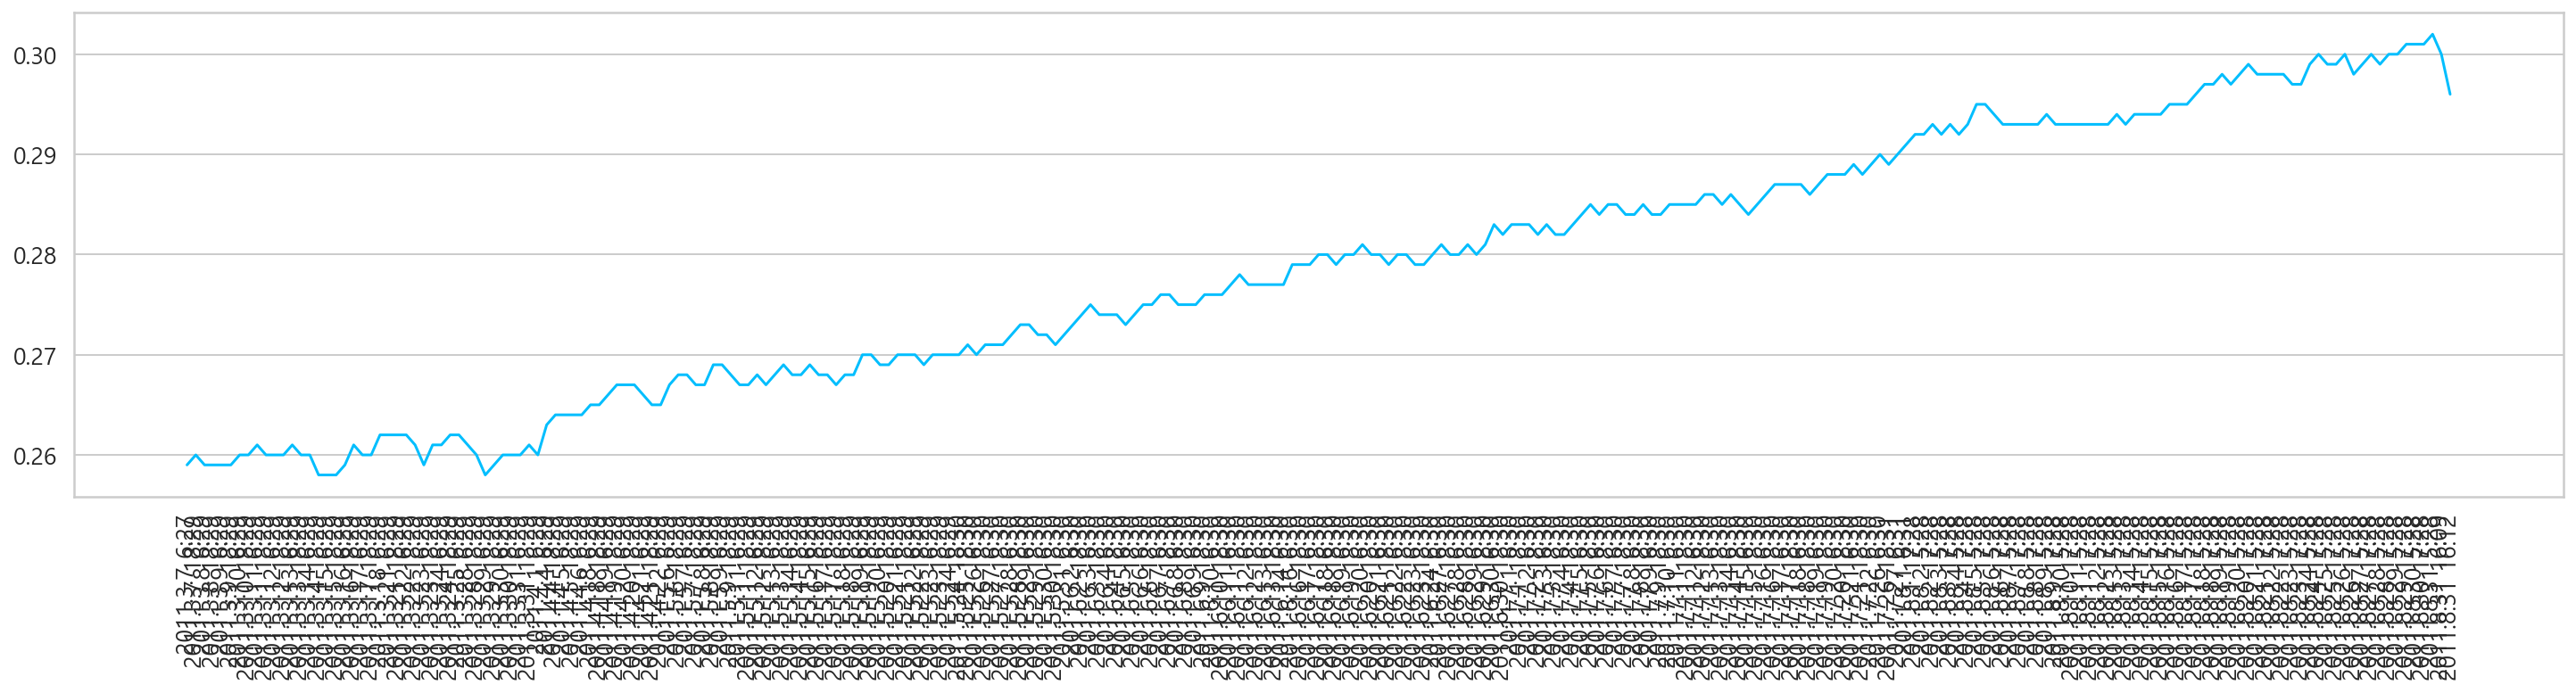

In [50]:
plt.figure(figsize=(25,5))
plt.plot(df['Resistance'])
plt.xticks(rotation=90)
plt.grid(axis='x')

# LSTM Model

In [51]:
X_cols = list(df.columns)
X_cols.remove('Resistance')

In [52]:
# 테스트 데이터 수
test_data_size = 14
# X변수들과 y변수 구분
X = df[X_cols]
y = df['Resistance']

In [53]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [54]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (245, 3)
test set :  (14, 3)


In [55]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res

In [56]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [57]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [58]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([245, 1, 3])
X_test : torch.Size([14, 1, 3])
y_train : torch.Size([245, 1])
y_test : torch.Size([14, 1])


# Building a Model

In [59]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [60]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [61]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=128
n_layers=8
lr=1e-4
num_epochs=600

In [62]:
# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.2359 test loss: 0.8256
Epoch 10 train loss: 0.1993 test loss: 0.7395
Epoch 20 train loss: 0.1642 test loss: 0.6496
Epoch 30 train loss: 0.1253 test loss: 0.5359
Epoch 40 train loss: 0.0791 test loss: 0.3451
Epoch 50 train loss: 0.0753 test loss: 0.1738
Epoch 60 train loss: 0.0713 test loss: 0.272
Epoch 70 train loss: 0.07 test loss: 0.249
Epoch 80 train loss: 0.0693 test loss: 0.2198
Epoch 90 train loss: 0.0676 test loss: 0.2361
Epoch 100 train loss: 0.0633 test loss: 0.2088
Epoch 110 train loss: 0.0455 test loss: 0.1453
Epoch 120 train loss: 0.0105 test loss: 0.0015
Epoch 130 train loss: 0.007 test loss: 0.0248
Epoch 140 train loss: 0.0061 test loss: 0.0314
Epoch 150 train loss: 0.0049 test loss: 0.008
Epoch 160 train loss: 0.004 test loss: 0.0155
Epoch 170 train loss: 0.0076 test loss: 0.0055
Epoch 180 train loss: 0.0034 test loss: 0.0129
Epoch 190 train loss: 0.0037 test loss: 0.0176
Epoch 200 train loss: 0.0029 test loss: 0.0103
Epoch 210 train loss: 0.0027 te

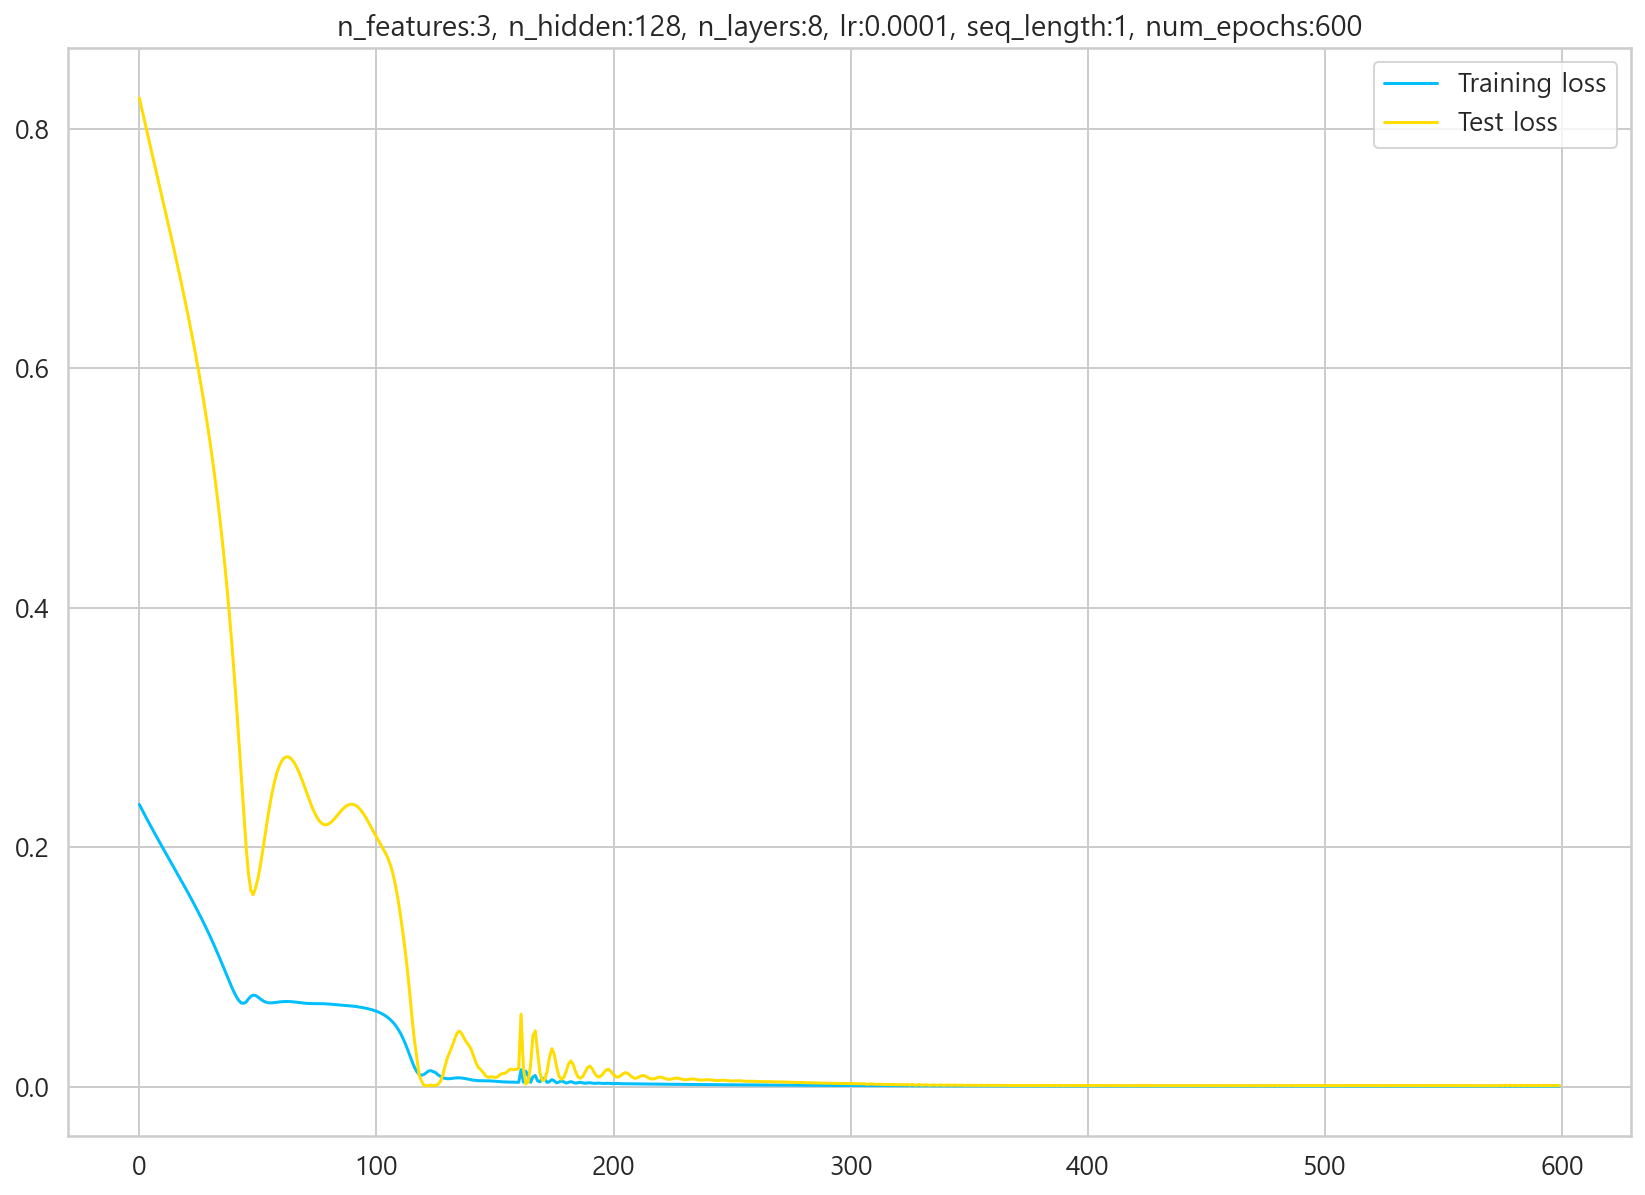

In [63]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

# Predicting daily cases

In [64]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [65]:
preds

[0.9579914808273315,
 0.9606768488883972,
 0.9633188843727112,
 0.965920627117157,
 0.9684851765632629,
 0.971015989780426,
 0.973516047000885,
 0.9759886264801025,
 0.9784365296363831,
 0.9808624386787415,
 0.9832687377929688,
 0.9856572151184082,
 0.9880297183990479,
 0.9903875589370728]

In [66]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [67]:
pred_values

array([[0.30015163],
       [0.30026978],
       [0.30038603],
       [0.30050051],
       [0.30061335],
       [0.3007247 ],
       [0.30083471],
       [0.3009435 ],
       [0.30105121],
       [0.30115795],
       [0.30126382],
       [0.30136892],
       [0.30147331],
       [0.30157705]])

In [68]:
pred_values_ceiled  = list(pred_values.flatten())

In [69]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [70]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [71]:
score_table

,True,Pred
0,0.299,0.300152
1,0.300,0.300270
2,0.298,0.300386
3,0.299,0.300501
4,0.300,0.300613
5,0.299,0.300725
6,0.300,0.300835
7,0.300,0.300943
8,0.301,0.301051
9,0.301,0.301158


In [72]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [73]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 3.4322138150655656e-06, RMSE : 0.0018526234952265842, SCORE : 99.99617924243435


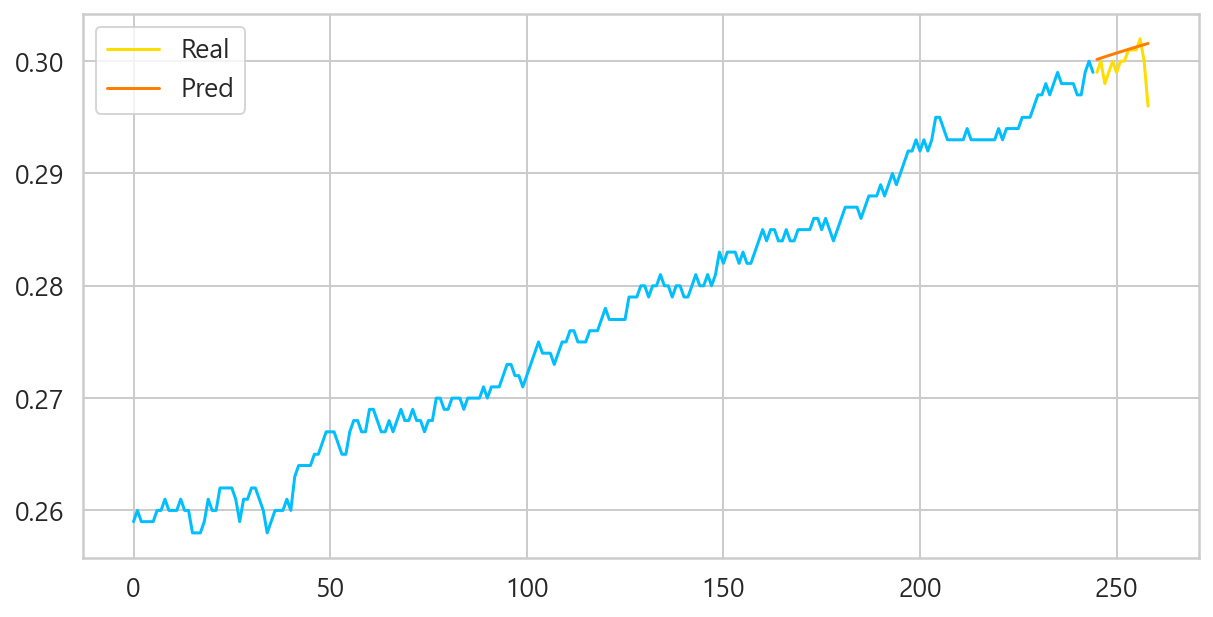

In [74]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [77]:
# 모델 저장
#PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
PATH = './models/{6}_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs, score.round(2))

torch.save(model, PATH)

In [78]:
# 모델 불러오기
#PATH = './models/score84_n_features_10_n_hidden_64_n_layers_4_lr_0.0001_seq_length_1_num_epochs_250.pth'
model = torch.load(PATH)
#model.eval()

# Use all data for training

In [135]:
test_df = pd.read_csv('./testset/J0003_0024_0221_20110307012732_cell_03.csv')

X_all = test_df[X_cols]
y_all = test_df['Resistance']
X_all = pd.DataFrame(X_all)
y_all = pd.DataFrame(y_all)

In [136]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
#Xscaler = scaler.fit(X_all)
# Y scaler 생성
#yscaler = scaler.fit(y_all.values.reshape(-1,1))
X_all = scaler.fit_transform(X_all)
y_all = scaler.fit_transform(y_all)
# 스케일링 적용
#X_all = Xscaler.transform(X_all)
#y_all = yscaler.transform(y_all.values.reshape(-1,1))
#y_all = y_all.flatten()
X_all = pd.DataFrame(X_all)
y_all = pd.DataFrame(y_all)

In [138]:
print(X_all.head())
print(y_all.head())

     0         1    2
0  0.0  0.333333  0.0
1  0.0  0.333333  0.0
2  0.0  0.666667  0.0
3  0.0  0.333333  0.0
4  0.0  0.666667  0.0
          0
0  0.047619
1  0.047619
2  0.000000
3  0.095238
4  0.047619


In [139]:
y_all

,0
0,0.047619
1,0.047619
2,0.000000
3,0.095238
4,0.047619
...,...
253,0.904762
254,0.904762
255,0.857143
256,1.000000


In [140]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (258, 3)
y_all :  (258, 1)


In [141]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [142]:
# model = CoronaVirusPredictor(
#   n_features=n_features,
#   n_hidden=n_hidden,
#   seq_len=seq_length,
#   n_layers=n_layers
# )
# model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=200, lr=lr)

# Predicting future cases

In [143]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [144]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [145]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[0.31941013741493224,
 0.3193797311782837,
 0.3193298034667969,
 0.3192452963590622,
 0.3191074093580246,
 0.3188946733474731,
 0.31858422231674194,
 0.3181535732746124,
 0.31758300322294236,
 0.3168583329319954,
 0.31597382462024687,
 0.31493470537662505,
 0.31375864541530607,
 0.31247565668821337]

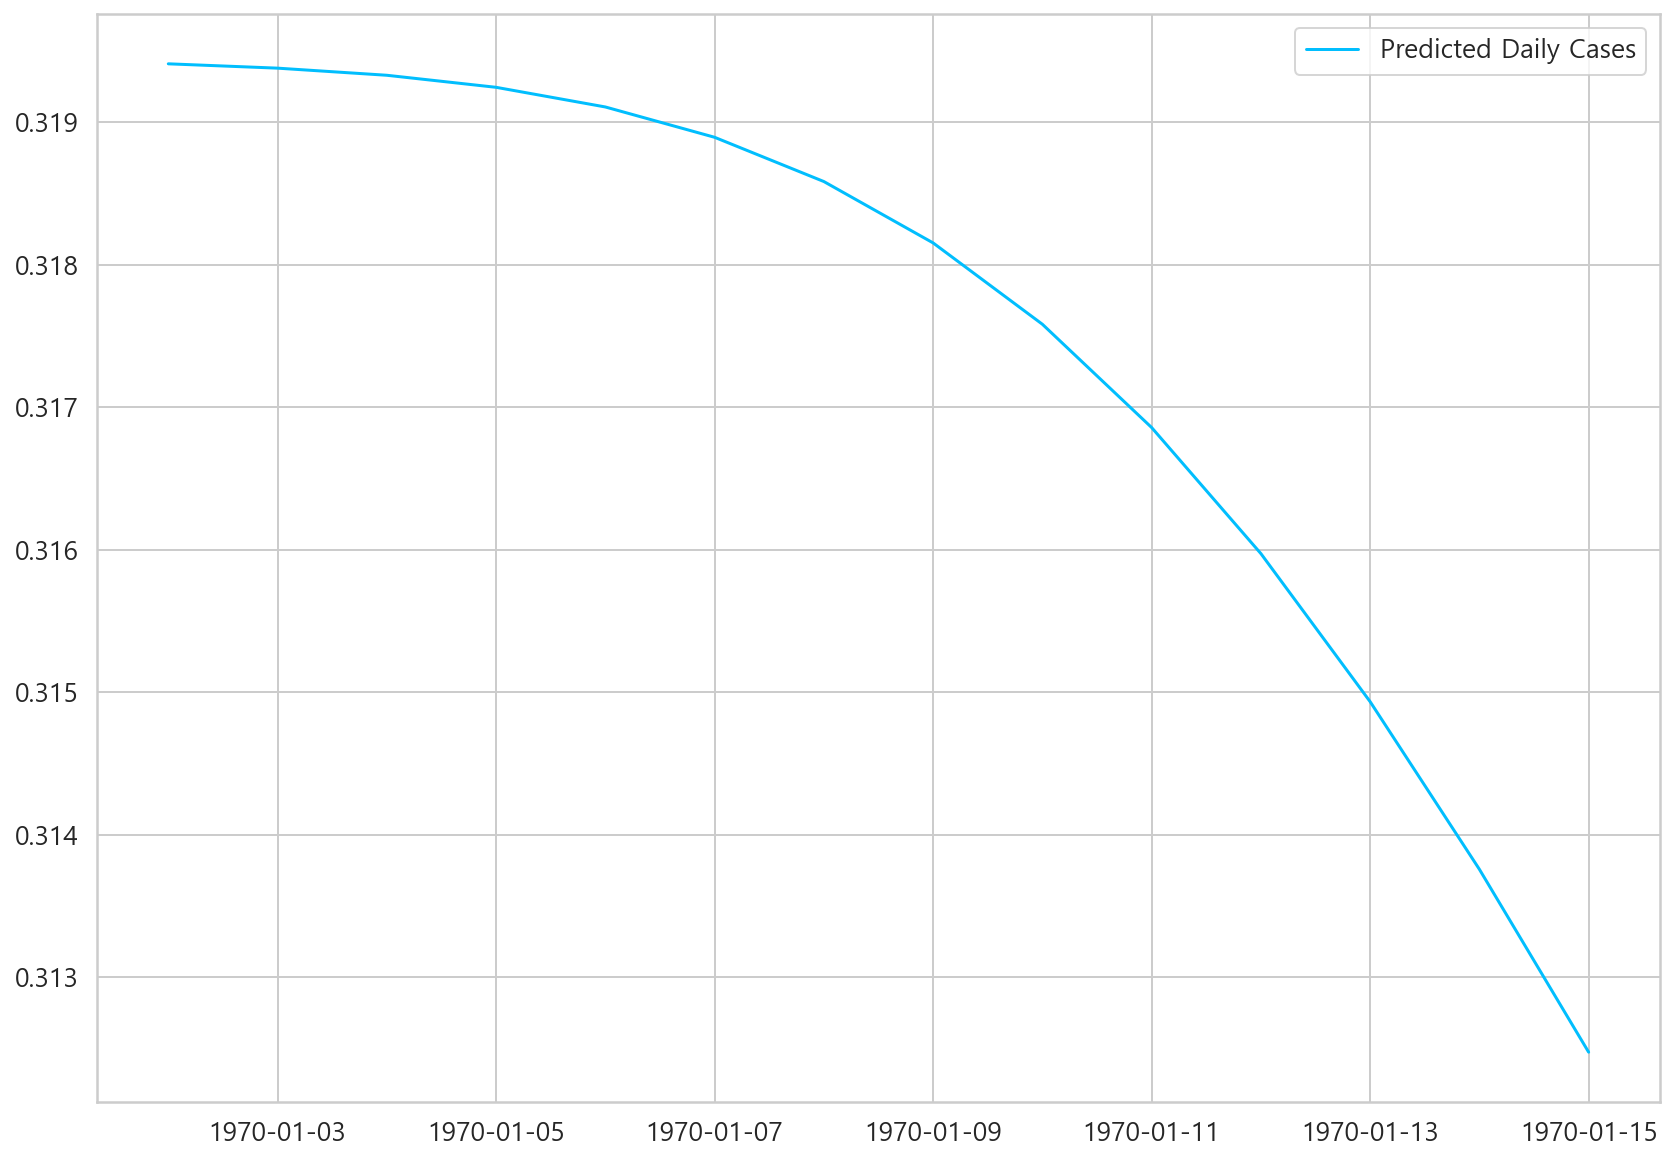

In [146]:
predicted_index = pd.date_range(
  start=test_df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [147]:
preds_ = pd.DataFrame(predicted_cases)
test_df.index = pd.to_datetime(test_df.index)

In [148]:
preds_

,0
1970-01-02 00:00:00.000000257,0.319410
1970-01-03 00:00:00.000000257,0.319380
1970-01-04 00:00:00.000000257,0.319330
1970-01-05 00:00:00.000000257,0.319245
1970-01-06 00:00:00.000000257,0.319107
1970-01-07 00:00:00.000000257,0.318895
1970-01-08 00:00:00.000000257,0.318584
1970-01-09 00:00:00.000000257,0.318154
1970-01-10 00:00:00.000000257,0.317583
1970-01-11 00:00:00.000000257,0.316858


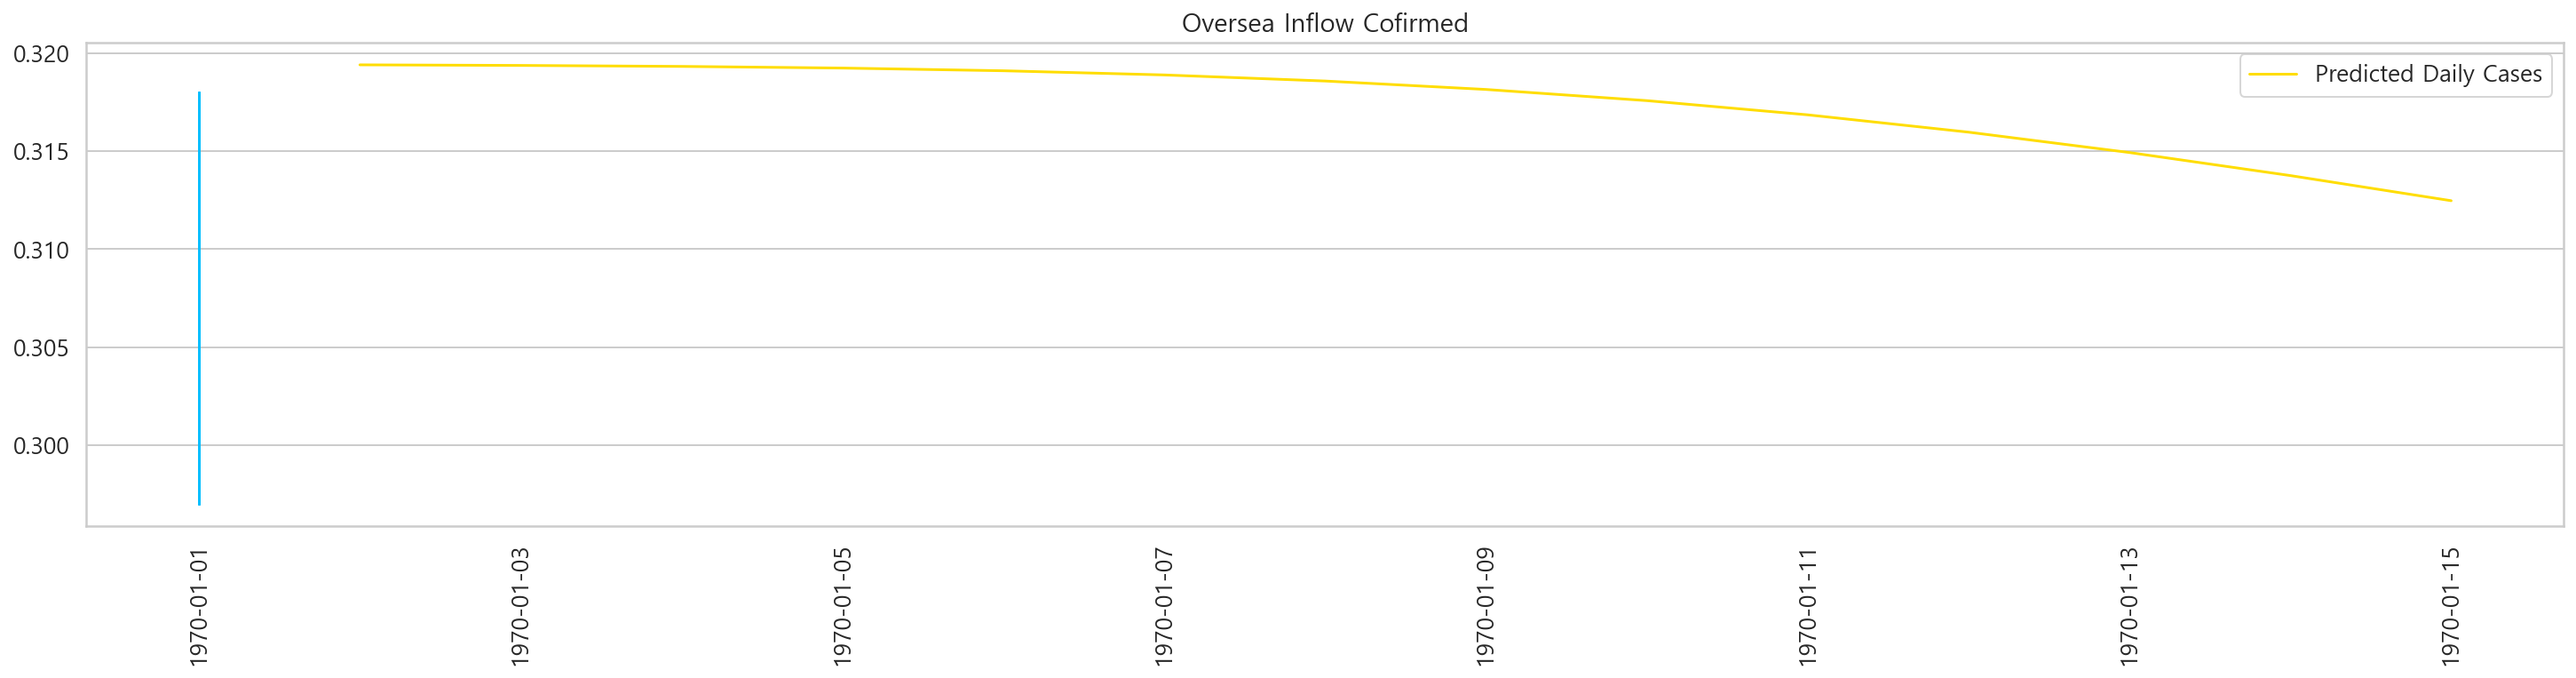

In [150]:
plt.figure(figsize=(25,5))
plt.plot(test_df['Resistance'])
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();